# AI Adoption and Layoffs: Multiple Regression

In this notebook, we extend our previous analysis regarding the relationship between AI adoption and layoffs adding more variables to our regression model in order to control for potential new factors that could influence layoffs.
Characteristics such as revenue growth, mergers and acquisitions, market capitalization, taxes, foreign direct investments (FDI), and sector dummies will be included in the analysis. The goal is to identify which factors are statistically significant and assess the robustness of the relationship between AI adoption and layoffs.

## 1. Data generation and full OLS model

We first generate a **synthetic but realistic dataset** of 100 firms.  
Each firm is assigned:
- an AI adoption score (0–100),
- financial variables (revenue growth, market capitalization, taxes, FDI),
- a binary variable indicating whether a merger/acquisition occurred,
- and an industry sector (Tech, Finance, Manufacturing).

The dependent variable `Layoffs` is simulated as a linear function of these predictors plus a random noise term.  
We then estimate a **multiple linear regression model** using the Ordinary Least Squares (OLS) method with `Layoffs` as the dependent variable.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

np.random.seed(42)
n = 100

# ============= 1) COSTRUISCO I DATI =============
ai_adoption = np.random.uniform(0, 100, n)
revenue_growth = np.random.normal(5, 10, n)
merger = np.random.binomial(1, 0.2, n)
market_cap = np.random.lognormal(mean=2, sigma=0.7, size=n)
taxes = np.random.normal(50, 15, n)
fdi = np.random.poisson(3, n)
sector = np.random.choice(["Tech", "Finance", "Manufacturing"], size=n)

layoffs = (
    20
    + 1.4 * ai_adoption
    - 0.3 * revenue_growth
    + 10 * merger
    + 0.8 * market_cap
    + 0.2 * taxes
    + 3 * fdi
    + np.random.normal(0, 15, n)
)

df = pd.DataFrame(
    {
        "Layoffs": layoffs,
        "AI_Adoption": ai_adoption,
        "RevenueGrowth": revenue_growth,
        "Merger": merger,
        "MarketCap": market_cap,
        "Taxes": taxes,
        "FDI": fdi,
        "Sector": sector,
    }
)

# ============= 2) DUMMY PER IL SETTORE =============
df = pd.get_dummies(df, columns=["Sector"], drop_first=True)

# ============= 3) MODELLO OLS COMPLETO =============
y = df["Layoffs"]
X = df.drop(columns=["Layoffs"]).astype(float)
X = sm.add_constant(X)

model_full = sm.OLS(y, X).fit()
print(model_full.summary())

                            OLS Regression Results                            
Dep. Variable:                Layoffs   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     156.5
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           9.29e-50
Time:                        17:27:13   Log-Likelihood:                -392.48
No. Observations:                 100   AIC:                             803.0
Df Residuals:                      91   BIC:                             826.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.9905 

## 2. Reduced model and model comparison

After examining the full model, we remove statistically insignificant variables  
(`RevenueGrowth`, `Sector_Manufacturing`, and `Sector_Tech`) to obtain a **reduced model** containing only the most relevant predictors:
`AI_Adoption`, `Merger`, `MarketCap`, `Taxes`, and `FDI`.

We compare the two specifications using:
- **AIC and BIC** (information criteria, lower is better),
- **Adjusted R²** (goodness of fit adjusted for number of regressors),
- and an **F-test for nested models** (ANOVA), which formally checks whether the excluded variables add explanatory power.

In [2]:
from statsmodels.stats.anova import anova_lm

# modello ridotto: tengo solo le variabili significative
X_reduced = df[["AI_Adoption", "Merger", "MarketCap", "Taxes", "FDI"]]
X_reduced = sm.add_constant(X_reduced)
model_reduced = sm.OLS(y, X_reduced).fit()
print(model_reduced.summary())

print("\n--- comparison ---")
print("AIC full:   ", model_full.aic)
print("AIC reduced:", model_reduced.aic)
print("BIC full:   ", model_full.bic)
print("BIC reduced:", model_reduced.bic)
print("Adj R² full:   ", model_full.rsquared_adj)
print("Adj R² reduced:", model_reduced.rsquared_adj)

# F-test tra i due modelli (sono annidati)
anova_results = anova_lm(model_reduced, model_full)
print("\nF-TEST BETWEEN MODELS")
print(anova_results)

                            OLS Regression Results                            
Dep. Variable:                Layoffs   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     250.8
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           9.98e-53
Time:                        17:27:13   Log-Likelihood:                -393.93
No. Observations:                 100   AIC:                             799.9
Df Residuals:                      94   BIC:                             815.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.0171      6.223      1.610      

## 3. Model fit visualization

This scatter plot compares **observed layoffs** (actual data) with **predicted layoffs** (fitted values from the OLS model).  
If the model fits the data well, the points should lie close to the red 45° line, indicating that predicted values are close to the observed ones.

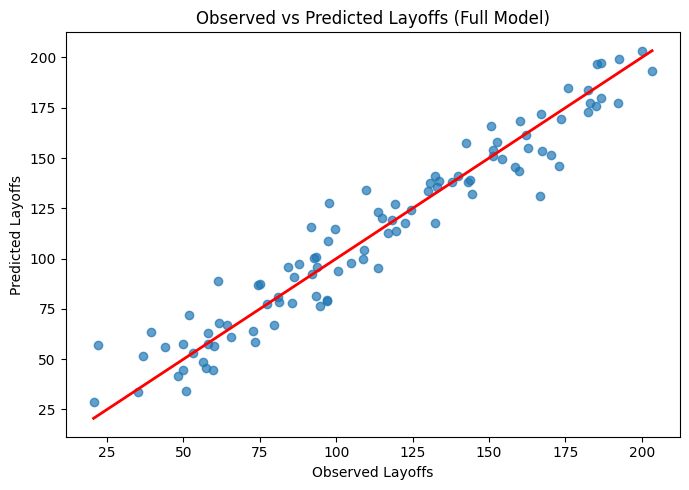

In [3]:
import matplotlib.pyplot as plt

y_pred = model_full.fittedvalues
residuals = model_full.resid  # lo usi anche dopo

plt.figure(figsize=(7, 5))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", lw=2)
plt.xlabel("Observed Layoffs")
plt.ylabel("Predicted Layoffs")
plt.title("Observed vs Predicted Layoffs (Full Model)")
plt.tight_layout()
plt.show()

## 4. Residual analysis (fitted values vs residuals)

We analyze the residuals (prediction errors) to assess whether the **linear model assumptions** hold.  
Ideally, residuals should be randomly scattered around zero without clear patterns.  
A funnel shape or trend would indicate heteroskedasticity or nonlinearity.

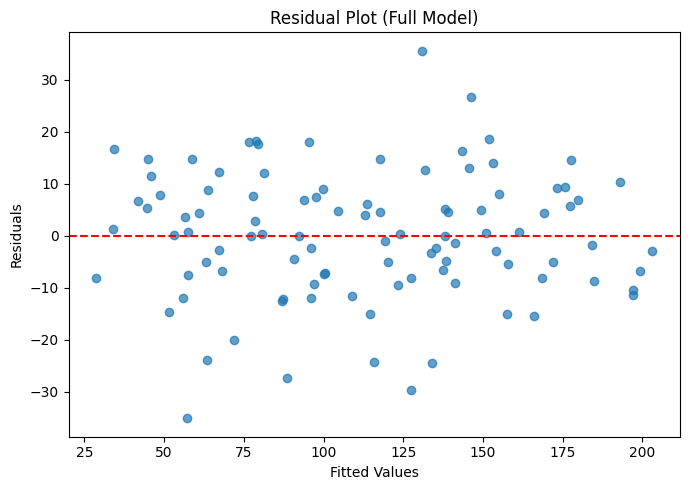

In [4]:
plt.figure(figsize=(7, 5))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Full Model)")
plt.tight_layout()
plt.show()

## 5. Distribution of residuals

Finally, we inspect the **distribution of residuals** using a histogram with a kernel density estimate (KDE).  
A roughly symmetric, bell-shaped curve centered at zero suggests that the normality assumption of OLS errors is reasonable.  
This confirms that the model residuals behave as expected for a well-specified linear regression.

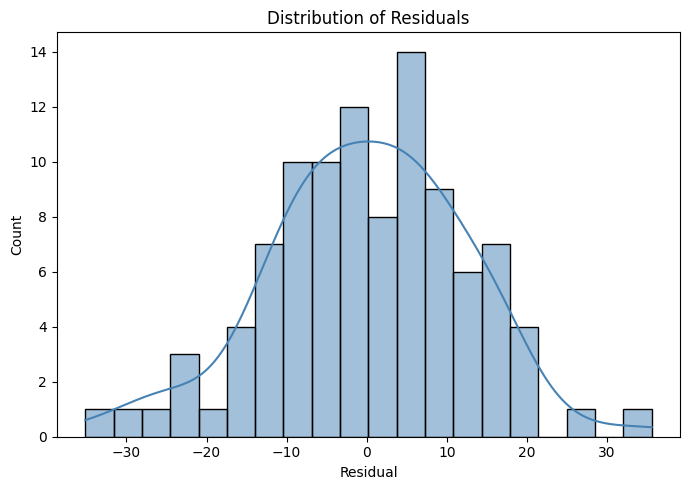

In [5]:
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, bins=20, color="steelblue")
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

## 6. Reduced model fit

We replicate the same “observed vs predicted” plot for the reduced model to visually confirm that its performance is comparable to the full model.  
Since both plots look very similar, this supports the statistical result that removing non-significant variables does not meaningfully worsen the model fit.

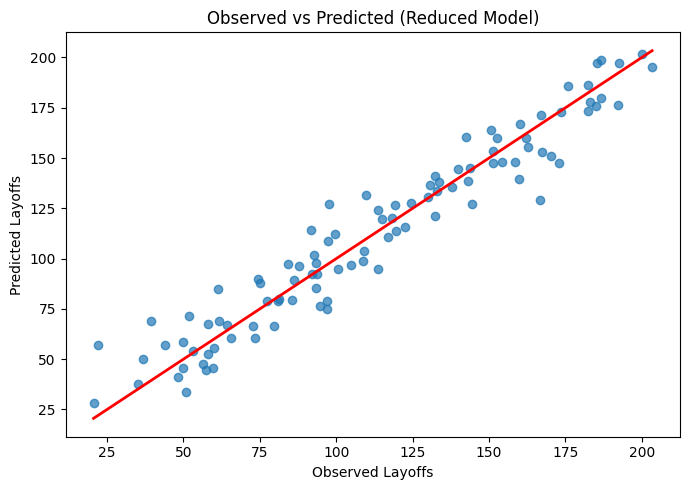

In [6]:
y_pred_red = model_reduced.fittedvalues

plt.figure(figsize=(7, 5))
plt.scatter(y, y_pred_red, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", lw=2)
plt.xlabel("Observed Layoffs")
plt.ylabel("Predicted Layoffs")
plt.title("Observed vs Predicted (Reduced Model)")
plt.tight_layout()
plt.show()